In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from scripts_unsupervised_utils import (
    run_unsupervised_audit,
    plot_pca_clusters,
    plot_pca_anomalies
)
from pipeline_trainer import BillingCostPredictor
import joblib
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
# === Step 1: Load Saved Model & Data ===
model = BillingCostPredictor()
model.load_data("/Users/tobyliu/PSTAT 131 Final Project/fivehunnidthou_df.csv")
model.clean_data()
model.preprocess()

✅ Data loaded: (500000, 34)
✅ Passed: df is a DataFrame
🔎 First 5 column names: ['Health Service Area', 'Hospital County', 'Operating Certificate Number', 'Facility ID', 'Facility Name']
🔎 df shape: (500000, 33)
🔍 APR Severity of Illness Code dtype: int64
🔍 Length of Stay dtype: float64
🔍 APR Risk of Mortality dtype: float64
✅ All numeric types validated
✅ Data cleaned and assigned: (500000, 34)
✅ Preprocessing done. Train shape: (400000, 1253), Test shape: (100000, 1253)


(        Operating_Certificate_Number  Facility_ID  Length_of_Stay  \
 269056                     7000006.0       3058.0             5.0   
 499174                     7002024.0       1456.0             3.0   
 85143                      2950001.0        527.0             6.0   
 260335                     3523000.0        699.0             3.0   
 338124                     1401014.0        207.0             7.0   
 ...                              ...          ...             ...   
 259178                      101003.0          4.0             6.0   
 365838                     7002053.0       1463.0             6.0   
 131932                     7001019.0       1304.0             1.0   
 146867                     5157003.0        943.0             7.0   
 121958                     2952006.0        551.0            19.0   
 
         Discharge_Year  CCS_Diagnosis_Code  CCS_Procedure_Code  APR_DRG_Code  \
 269056          2011.0               254.0               213.0         860.0

In [39]:
X_unsup = model.X_test.drop(columns=[
    'Total Charges', 
    'Log Total Charges', 
    'Total Costs'
], errors='ignore')

In [40]:
# === Step 2: Impute and Run Unsupervised Audit ===
imputer = SimpleImputer(strategy="mean")

# Apply imputer directly to model.X_test
X_imputed = pd.DataFrame(
    imputer.fit_transform(model.X_test),
    index=model.X_test.index
)

X_unsup = model.X_test.drop(columns=[
    'Total Charges', 'Log Total Charges', 'Total Costs'
], errors='ignore')

# Run audit with imputed data (no dropna!)
audit_df, explained_var = run_unsupervised_audit(
    X_imputed,
    n_clusters=5,
    contamination=0.01
)

/opt/anaconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['APR_Risk_of_Mortality']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


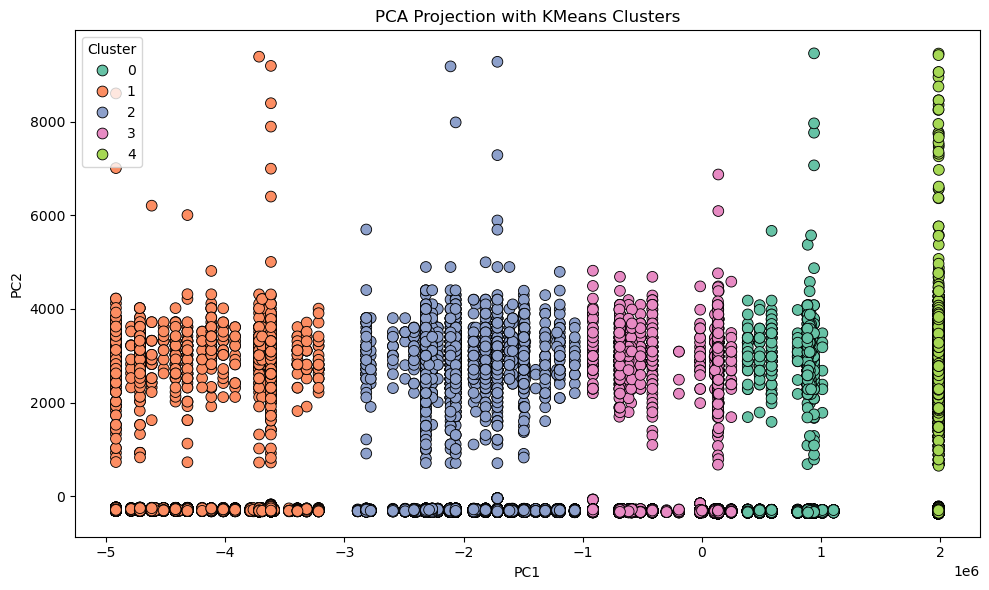

In [41]:
# === Step 3: Plot PCA Clusters ===
plot_pca_clusters(audit_df)

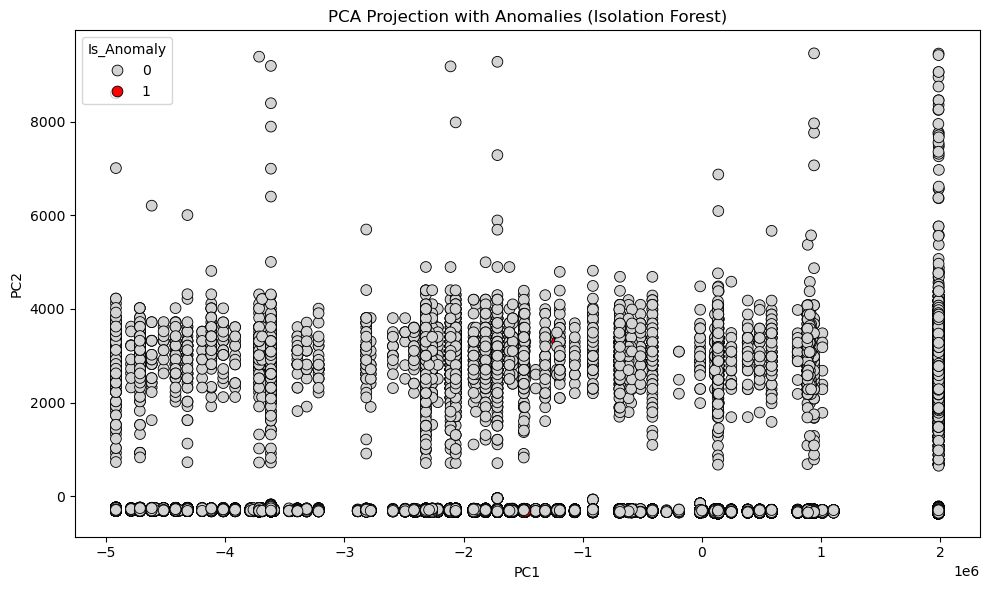

In [42]:
# === Step 4: Plot PCA Anomalies ===
plot_pca_anomalies(audit_df)

In [43]:
# === Step 5: Print Summary Stats ===
print("\n🔎 Explained Variance Ratio (PC1 + PC2):", f"{sum(explained_var[:2]):.2%}")
print("\n🧪 Cluster Distribution:")
print(audit_df['Cluster'].value_counts())


🔎 Explained Variance Ratio (PC1 + PC2): 100.00%

🧪 Cluster Distribution:
Cluster
4    46891
2    22182
1    13079
3    11013
0     6835
Name: count, dtype: int64


In [44]:
print("\n🚨 Anomaly Counts:")
print(audit_df['Is_Anomaly'].value_counts())


🚨 Anomaly Counts:
Is_Anomaly
0    99000
1     1000
Name: count, dtype: int64


In [45]:
# Step 1: Impute X_test
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(model.X_test), index=model.X_test.index)

/opt/anaconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['APR_Risk_of_Mortality']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [46]:
# Step 2: Fit KMeans manually
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [47]:
sample_size = 10000  # or 25000 if you have RAM for it
X_sample = X.sample(n=sample_size, random_state=42)
labels_sample = kmeans.predict(X_sample)

In [48]:
score = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.851


In [49]:
# === Step 6: Save for Additional Analysis (optional) ===
audit_df.to_csv("reports/unsupervised_audit_results.csv", index=False)
print("\n✅ Saved audit results to 'reports/unsupervised_audit_results.csv'")

KeyboardInterrupt: 